# Latent SDEs 

This notebook serves as a demo for recovering the latent drift of a SDE assumed to be governing some set of observed data.  

### Background.

To setup the problem, suppose we observe data $\{X_t\}, X_t \in \mathbb{R}^d$ such that $X_t = f(Z_t) + \epsilon$ and $Z_t \in \mathbb{R}^k, k \leq d$ satisifies the following stochastic differential equation 
$$
\mathrm{d}Z_t = \mu(Z_t, t) \mathrm{d}t + \sigma(Z_t, t) \mathrm{d}W_t. 
$$
Additionally, suppose that $Z_t$ is reducible; that is, there exists some transformation $\phi(Z_t)$ such that $\phi(Z_t)$ satisfies a stochastic differential equation with unit diffusion.
We will consider learning diffusions of the sort in the notebook. 

### Python packages.
For this tutorial, we will use the PyTorch framework to easily compute gradients needed. Specifically, we will represent the drift $\mu$ as a multi-layered perceptron. We will additionally represent the encoding and decoding functions as neural networks. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import math
import yaml
import pickle
import pprint 
import os
import logging
import sys

import data_loaders
import nets
import losses
import utils
import setup


The way that the data is loaded into the program is using a `yaml` file. We have one called `dot-ou.yaml` in the directory, and we will use that for this experiment. The `yaml` file keeps track of all the parameters for the experiment, which we will detail now. 


Now we write out the training function. This is very basic function that trains the autoencoder simultaneously with the latent diffusion to find the parameters of the latent diffusion. 

In [5]:
def train(ae, 
        mu, 
        sigma, 
        dt, 
        train_data, 
        val_data, 
        optimizer, 
        scheduler, 
        n_epochs, 
        data_params,
        **kwargs):

    '''
    The main training routine:

    ae : neural network (torch.Module subclass) that represents our autoencoder
    mu : network or parameter that describes the latent drift
    sigma : network or parameter that describes the latent diffusion
    dt : time step
    train_data : dataloader with the training data
    val_data : dataloader with validation data
    optimizer : optimization algorithm torch.optim 
    scheduler : lr decay schedule
    n_epochs  : number of epochs to run
    data_params : parameters associated with the dataset

    returns statistics with respect to training
    '''
    print('Train function')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    global savepath
    global loss_type

    train_dataset = train_data.dataset.dataset
    val_dataset   = val_data.dataset.dataset
    
    try:
        inner_num = data_params['inner_iter']
    except:
        inner_num = 5

    if n_epochs > 1000:
        reserve_epoch = 499
    else:
        reserve_epoch = 49

    losses_train = []
    losses_valid = []
    
    lambda_sigma = 20 # hyperparameter on the sparsity term (for learning the latent dimensions)

    # setup the stats dict
    stats = {'kl': np.Inf, 
            'l2' : np.Inf, 
            'l2_valid': np.Inf, 
            'kl_valid': np.Inf, 
            'mu_mse': 0, 
            'mu_mse_valid': 0, 
            'mu_rel': 0,
            'mu_rel_valid': 0,
            'sde_mse': 0, 
            'sde_mse_valid': 0,
            'sde_rel': 0,
            'sde_rel_valid': 0,
            'val_cond_met': False}

    for epoch in range(n_epochs+1):

        ae.train()
        mu.train()

        for idx, (frames, ts) in enumerate(train_data):

            # transfer the data to the device
            # the rest is boilerplate
            frames = frames.float().to(device)
            ts     = ts.float().to(device)

            for _ in range(inner_num):

                optimizer.zero_grad()

                kl_loss, l2_loss,\
                        frames_hat, mu_hat, q_mu, sigma_hat_full, q_sigma_full, inc, z = ae.step(frames, ts, dt, mu, sigma)


                kl_loss1, l2_loss1,\
                        _, _, _, _, _, _, _ = ae.step(frames, ts, dt, mu, sigma, plus_one=True)

                sigma.data = sigma / sigma.norm(2) * torch.ones(z.shape[1]).norm(2)

                loss = kl_loss + kl_loss1 + l2_loss + l2_loss1 + lambda_sigma*sigma.norm(1)

                losses_train.append((kl_loss.item(), l2_loss.item()))

                loss.backward()
                optimizer.step()

                # And that's the end of the train routine
                
            if idx == 0 and (epoch) % 100 == 0:
                print(epoch)
                # plot some of the variables every 200 epochs
                # calculate the affine map between xt and z
                current_run = train_dataset.xt_orig[idx*z.shape[0]:(idx+1)*z.shape[0]]
                scale = (train_dataset.xt_orig.max() - train_dataset.xt_orig.min())

                q_mu = q_mu[:, :train_dataset.xt_orig.shape[1]]
                z    = z[:, :train_dataset.xt_orig.shape[1]]
                
                d = train_dataset.xt_orig.shape[1]

                q_max = q_mu.max()
                q_min = q_mu.min()

                if loss_type == 'exact': 
                    q_scaled = ((q_mu - q_min ) / (q_max - q_min) * (scale) ).detach().cpu().numpy()
                else:
                    q_scaled = q_mu.detach().cpu().numpy() / scale

                # Compute the transformation between coordinates
                transformed_xt, Q, b, sde_mse, sde_rel = utils.calc_affine(
                        current_run,
                        q_scaled,
                        None, 
                        affine=False)

                # Plot the coordinates after transformation
                for plot_idx in range(d):
                    plt.subplot(int('1{}{}'.format(d,plot_idx+1)))
                    plt.plot(current_run[:,plot_idx],label='Original')
                    plt.plot(transformed_xt[:,plot_idx],label='Estimated')
                plt.legend()
                plt.show()


                # Plot the images 
                im_grid_hat = torchvision.utils.make_grid(frames_hat[:64].detach().cpu(), pad_value=1, normalize=False)
                im_grid = torchvision.utils.make_grid(frames[:64].detach().cpu(), pad_value=1, normalize=False)
                plt.subplot(121)
                plt.imshow(im_grid.cpu().numpy().transpose((1,2,0)))
                plt.subplot(122)
                plt.imshow(im_grid_hat.cpu().numpy().transpose((1,2,0)))
                plt.show()

                mu_residuals, mu_rel, mu_crlb, plots, titles = utils.compare_mu2(
                    mu, 
                    q_mu, 
                    ts, 
                    Q, 
                    b, 
                    dt, 
                    train_dataset, 
                    None, 
                    affine=False,
                    loss_type=loss_type)
                n_plots = len(plots)
                for plot_idx in range(n_plots):
                    plt.subplot(int('1{}{}'.format(n_plots,plot_idx+1)))
                    plt.plot(*plots[plot_idx])
                plt.show()



Finally, we set up some parameters that we want to use during training. These come from the `yaml` file we discussed previously. The rest is boilerplate code. 

## Ornstein-Uhlenbeck with Yellow Balls

[1, 0, 0, 1]
PATH
results/dot-ou-final_d=ballsw=8z=2det=0lat=const-sig-ntloss=exactsigma=diag/run0/data.pkl
No original data found, assuming data not corrupt with noise
Using original mu as computed mu
Total number of parameters in autoencoder: 166303


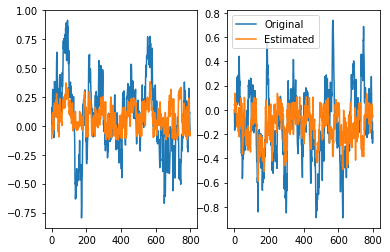

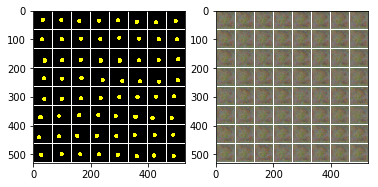

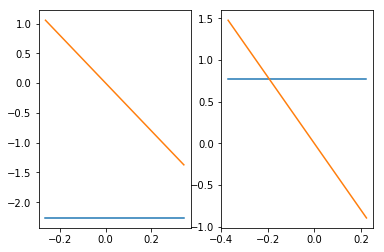

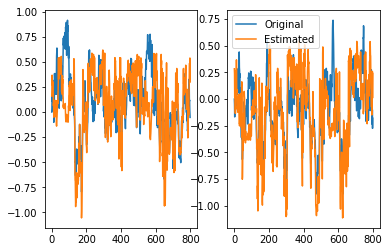

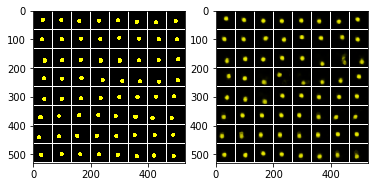

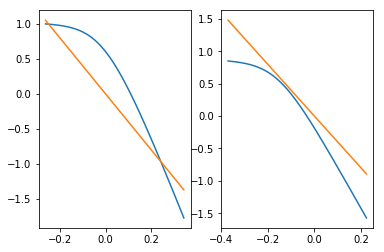

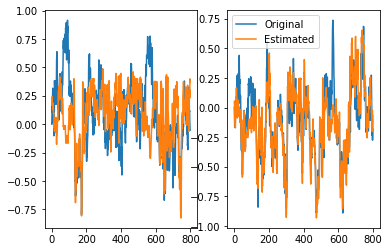

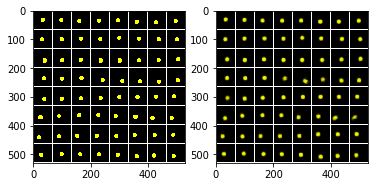

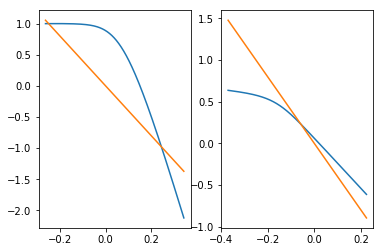

In [3]:
yaml_filepath = 'dot-ou.yaml' # Specify the yaml file for the experiment

run = 0

with open(yaml_filepath, 'r') as f:
    cfg = yaml.load(f, yaml.SafeLoader) # Load the yaml file into the cfg variable
    
# set up the save path    
savepath = 'results/{}_d={}w={}z={}det={}lat={}loss={}sigma={}/run{}'.format(
        cfg['head'],
        cfg['dataset']['name'],
        cfg['ae']['net']['width'], 
        cfg['ae']['net']['latent_dim'], 
        cfg['ae']['net']['add_det'],
        cfg['sde']['type'],
        cfg['ae']['net']['loss'],
        cfg['ae']['net']['sigma_type'],
        run)

global loss_type
loss_type = cfg['ae']['net']['loss']

if not os.path.exists(savepath):
    os.makedirs(savepath)

if not os.path.exists(os.path.join(savepath,'movies')):
    os.makedirs(os.path.join(savepath,'movies'))

if not os.path.exists(os.path.join(savepath,'saved_nets')):
    os.makedirs(os.path.join(savepath,'saved_nets'))
    
initialized = setup.setup(cfg, savepath)
stats = train(**initialized)

## Circle SDE with Red MNIST Digits
Let's now try one with the mnist dataset. This will have the mnist digits moving according to an SDE. 

[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
PATH
results/mnist-circ-final_d=smnist-dw=8z=4det=0lat=const-sig-ntloss=exactsigma=diag/run0/data.pkl
No original data found, assuming data not corrupt with noise
Using original mu as computed mu
Total number of parameters in autoencoder: 190883
Train function
0


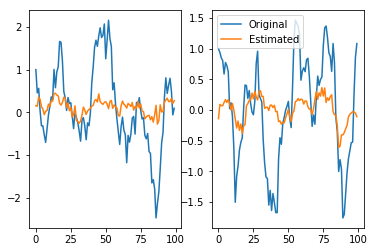

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


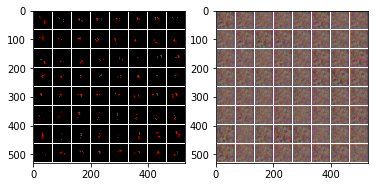

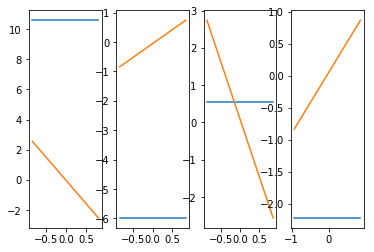

100


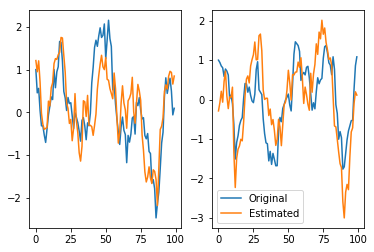

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


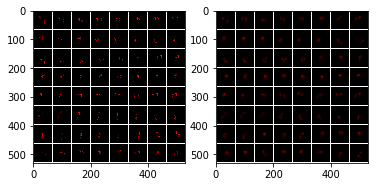

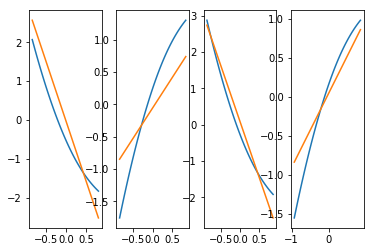

200


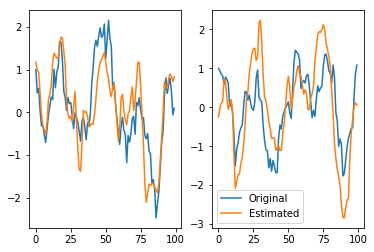

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


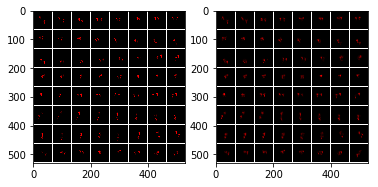

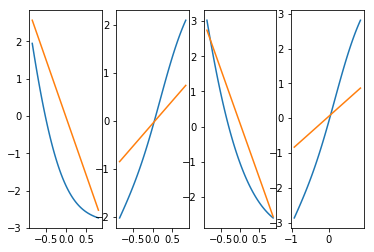

In [9]:
yaml_filepath = 'mnist-circ.yaml' # Specify the yaml file for the experiment

run = 0

with open(yaml_filepath, 'r') as f:
    cfg = yaml.load(f, yaml.SafeLoader) # Load the yaml file into the cfg variable
    
# set up the save path    
savepath = 'results/{}_d={}w={}z={}det={}lat={}loss={}sigma={}/run{}'.format(
        cfg['head'],
        cfg['dataset']['name'],
        cfg['ae']['net']['width'], 
        cfg['ae']['net']['latent_dim'], 
        cfg['ae']['net']['add_det'],
        cfg['sde']['type'],
        cfg['ae']['net']['loss'],
        cfg['ae']['net']['sigma_type'],
        run)

global loss_type
loss_type = cfg['ae']['net']['loss']

if not os.path.exists(savepath):
    os.makedirs(savepath)

if not os.path.exists(os.path.join(savepath,'movies')):
    os.makedirs(os.path.join(savepath,'movies'))

if not os.path.exists(os.path.join(savepath,'saved_nets')):
    os.makedirs(os.path.join(savepath,'saved_nets'))
    
initialized = setup.setup(cfg, savepath)
stats = train(**initialized)

## Wasserstein Interpolation of COIL-20 Data for Double Well
Finally let's look at interpolating according to the Wasserstein barycenter between two images from the COIL-20 dataset. 

[1]
PATH
results/wass-well-final_d=wassw=8z=1det=0lat=const-sigloss=exactsigma=diag/run0/data.pkl
No original data found, assuming data not corrupt with noise
Using original mu as computed mu
Total number of parameters in autoencoder: 154013
Train function
0


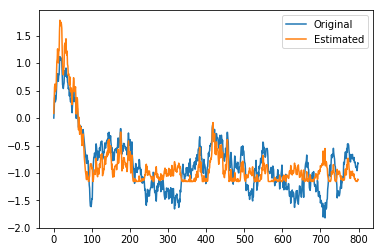

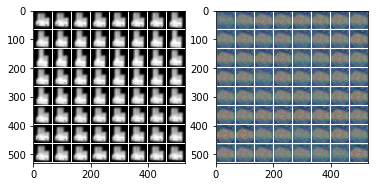

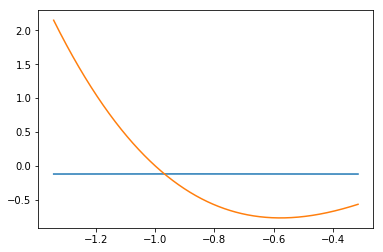

100


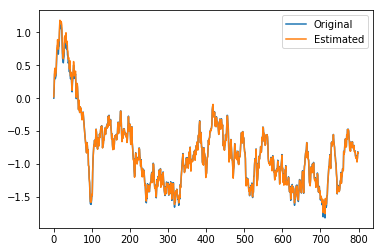

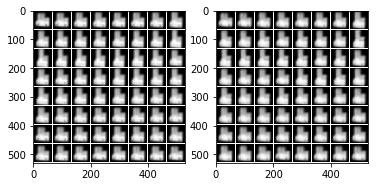

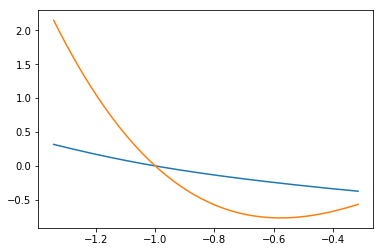

200


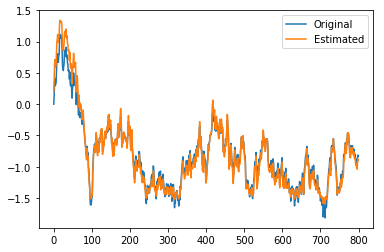

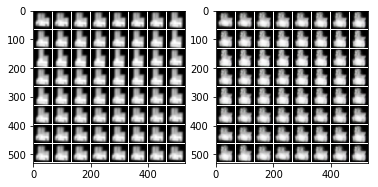

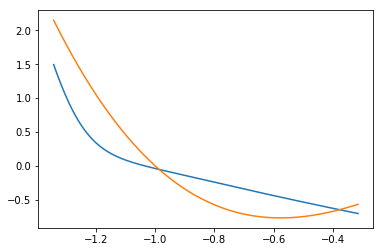

300


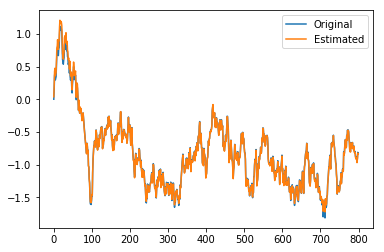

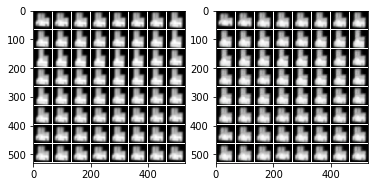

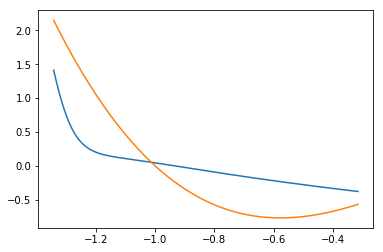

400


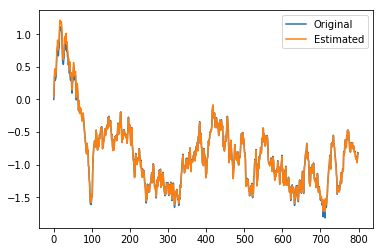

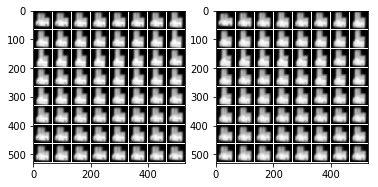

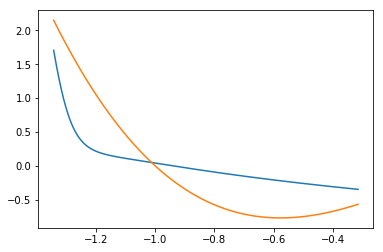

500


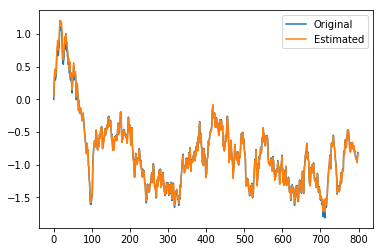

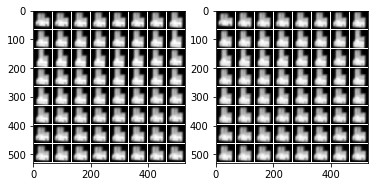

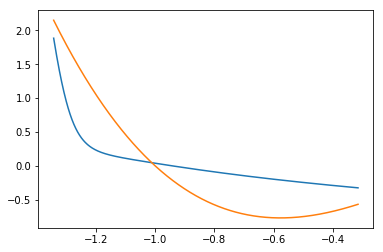

In [9]:
yaml_filepath = 'wass-well.yaml' # Specify the yaml file for the experiment

run = 0

with open(yaml_filepath, 'r') as f:
    cfg = yaml.load(f, yaml.SafeLoader) # Load the yaml file into the cfg variable
    
# set up the save path    
savepath = 'results/{}_d={}w={}z={}det={}lat={}loss={}sigma={}/run{}'.format(
        cfg['head'],
        cfg['dataset']['name'],
        cfg['ae']['net']['width'], 
        cfg['ae']['net']['latent_dim'], 
        cfg['ae']['net']['add_det'],
        cfg['sde']['type'],
        cfg['ae']['net']['loss'],
        cfg['ae']['net']['sigma_type'],
        run)

global loss_type
loss_type = cfg['ae']['net']['loss']

if not os.path.exists(savepath):
    os.makedirs(savepath)

if not os.path.exists(os.path.join(savepath,'movies')):
    os.makedirs(os.path.join(savepath,'movies'))

if not os.path.exists(os.path.join(savepath,'saved_nets')):
    os.makedirs(os.path.join(savepath,'saved_nets'))
    
initialized = setup.setup(cfg, savepath)
stats = train(**initialized)

These examples illustrate how to run the code and how to simulate different types of synthetic data and how to estimate the underlying SDE from realizations of the data. The figures in the notebook show a qualitative comparison, but we can do a quantitative comparison using the MSE between the learned function and the true function (as is done in the `comp_crlb.py` script and reported in the original paper). 